# Hough Transform

In this notebook, we will implement a Hough transform in order to detect parametric curves, such as lines or circles.
In the following, we shortly review the motivation for this technique.

Consider the point $p=(\mathtt{x},\mathtt{y})$ and the equation for a line $y = mx+c$. What are the lines that could pass through $p$?
The answer is simple: all the lines for which $m$ and $c$ satisfy $\mathtt{y} = m\mathtt{x}+c$.
Regarding $(\mathtt{x},\mathtt{y})$ as fixed, the last equation is that of a line in $(m,c)$-space.
Repeating this reasoning, a second point $p'=(\mathtt{x}',\mathtt{y}')$ will also have an associated line in parameter space, and the two lines will intersect at the point $(\tilde{m},\tilde{c})$, which corresponds to the line connecting $p$ and $p'$.

In order to find lines in the input image, we can thus pursue the following approach.
We start with an empty accumulator array quantizing the parameter space for $m$ and $c$.
For each edge pixel in the input image, we then draw a line in the accumulator array and increment the corresponding cells.
Edge pixels on the same line in the input image will produce intersecting lines in $(m,c)$-space and will thus reinforce the intersection point.
Maxima in this array thus correspond to lines in the input image that many edge pixels agree on.

In practice, the parametrization in terms of $m$ and $c$ is problematic, since the slope $m$ may become infinite.
Instead, we use the following parametrization in polar coordinates:
\begin{equation}
	\mathtt{x}\cos\theta + \mathtt{y}\sin\theta = \rho \label{eq:hough_line}
\end{equation}
This produces a sinusoidal curve in $(\rho,\theta)$-space, but otherwise the procedure is unchanged.


In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

## Hough Voting
Build up an accumulator array ``acc`` for the parameter space $(\rho, \theta)$. $\theta$ ranges from $-\pi/2$ to $\pi/2$, and $\rho$ ranges from $-D$ to $D$, where $D$ denotes the length of the image diagonal.
Use ``n_bins_rho`` and ``n_bins_theta`` as the number of bins in each direction.
Initially, the array is filled with zeros.

For each edge pixel in the input image, create the corresponding curve in $(\rho, \theta)$ space by evaluating above line equation for all values of $\theta$ and incrementing the corresponding cells of the accumulator array.

In [ ]:
def hough_transform(edge_image, n_bins_rho, n_bins_theta):
    # Vote accumulator
    votes = np.zeros((n_bins_rho, n_bins_theta), dtype=np.int)  
    
    # Create bins
    diag = np.linalg.norm(edge_image.shape)  # Length of image diagonal
    theta_bins = np.linspace(-np.pi / 2, np.pi / 2, n_bins_theta)
    rho_bins = np.linspace(-diag, diag, n_bins_rho)
    
    # Precompute sine and cosine
    cos_thetas = np.cos(theta_bins)
    sin_thetas = np.sin(theta_bins)
    
    # Hough transform
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            # If not an edge pixel, continue.
            if not edge_image[y, x]:
                continue
            
            # Cast votes
            for theta_idx, (cos_theta, sin_theta) in enumerate(zip(cos_thetas, sin_thetas)):
                # Compute rho given sine and cosine of theta
                rho = x * cos_theta + y * sin_theta  
                # Find bin index of rho
                rho_idx = int((rho+diag)/(2*diag)*n_bins_rho)  
                # Accumulate vote
                votes[rho_idx, theta_idx] += 1              
                
    return votes, rho_bins, theta_bins

Now we can test the implementation on an example image and visualize the resulting Hough space by displaying it as a 2D image.

<IPython.core.display.Javascript object>


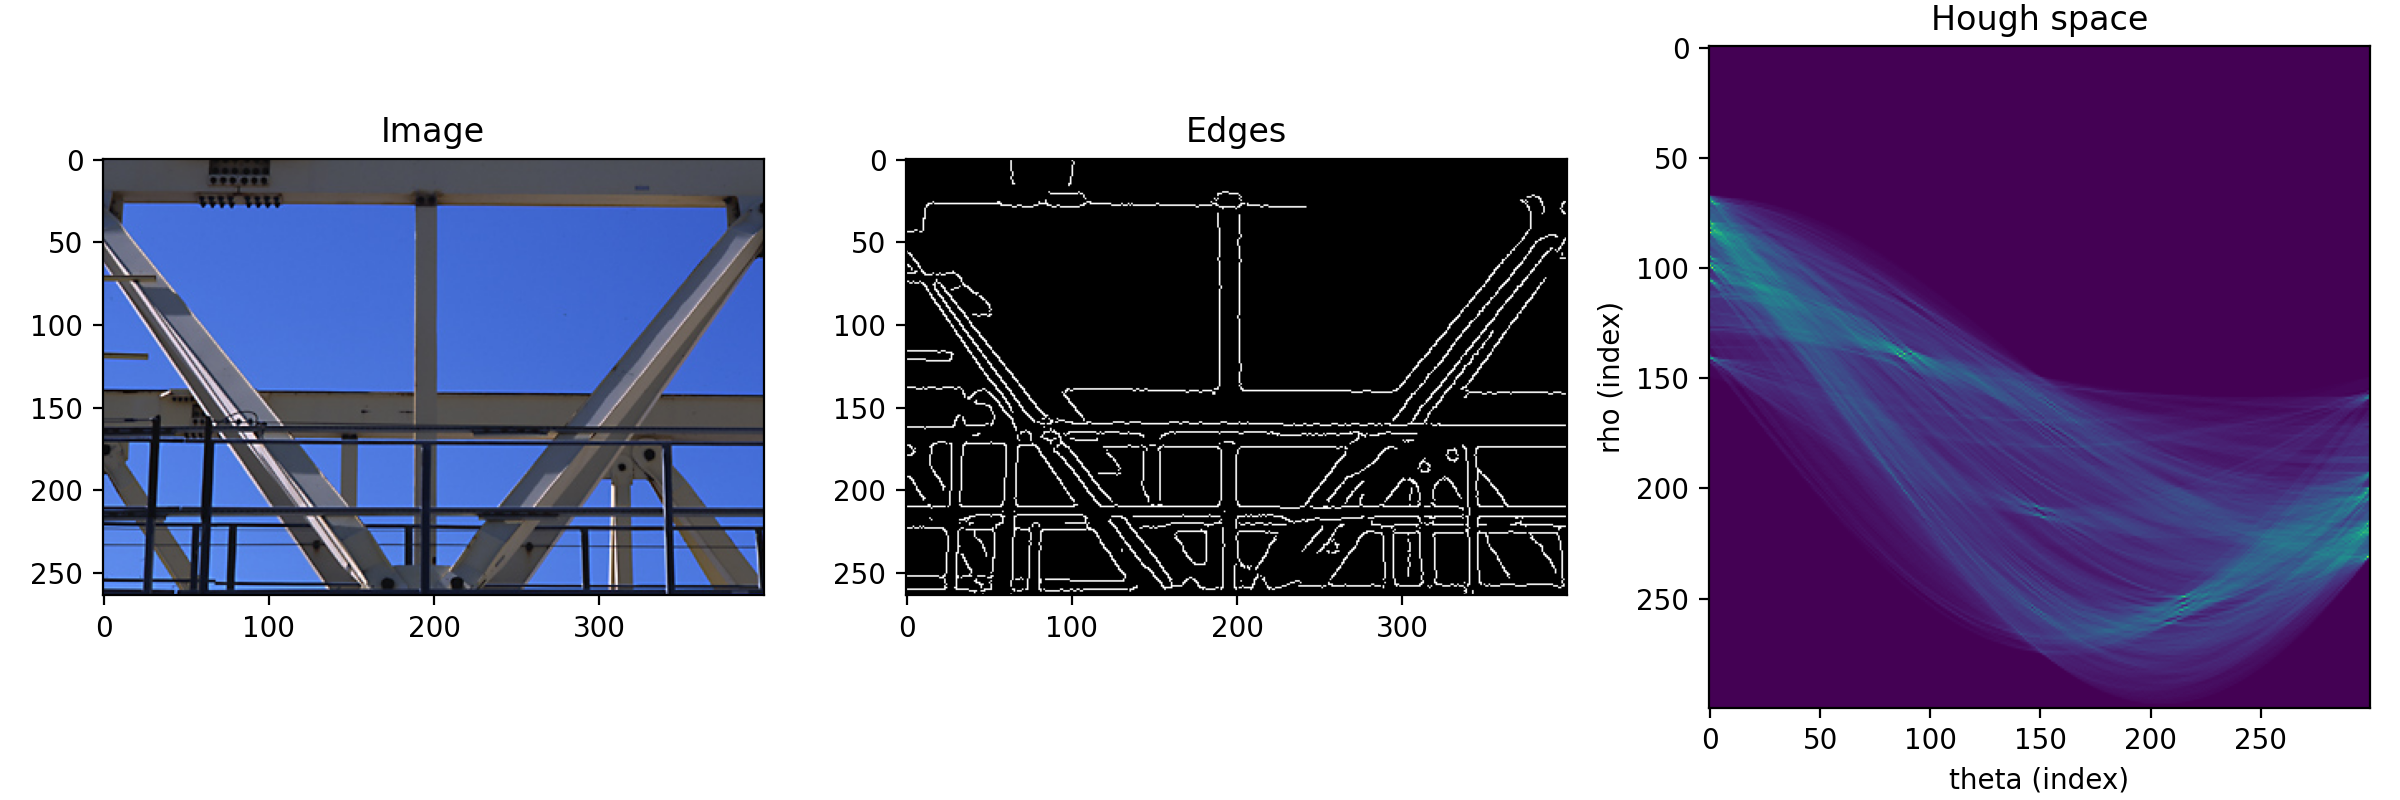

In [4]:
color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY)

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

hough_space, rho_bins, theta_bins = hough_transform(edges, n_bins_rho=300, n_bins_theta=300)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(color_im)
axes[0].set_title('Image')
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges')
axes[2].imshow(hough_space)
axes[2].set_title('Hough space')
axes[2].set_xlabel('theta (index)')
axes[2].set_ylabel('rho (index)')
fig.tight_layout()

## Non-Maximum Suppression and Finding Peaks
The function ``nms2d`` suppresses all points in the Hough space that are not local maxima.
This can be achieved by looking at the 8 direct neighbors of each pixel and keeping only pixels whose value is greater than all its neighbors.

This function is simpler than the non-maximum suppression from the Canny Edge Detector exercise, since it does not take into account local gradients.


In [ ]:
def nms2d(hough_array):
    hough_array_out = np.zeros_like(hough_array)
    
    # To make life easier, we skip the array boundaries,
    # because those have fewer than 8 neighbors
    # This is a bit sloppy, but makes the code simpler to read.
    for x in range(1, hough_array.shape[1] - 1):
        for y in range(1, hough_array.shape[0] - 1):
            val = hough_array[y, x]

            # Get value of neighbor pixels
            x_neighbor = x + np.array([1, 1, 0, -1, -1, -1, 0, 1])
            y_neighbor = y + np.array([0, 1, 1, 1, 0, -1, -1, -1])
            # Note how in the next line we are using an array in place of an index.
            # This is one of the several ways numpy can make it easy and compact to work with arrays.
            val_neighbor = hough_array[y_neighbor, x_neighbor]
            
            # If the pixel value is larger than all neighbor values
            if np.all(val_neighbor <= val):
                hough_array_out[y, x] = val
                
    return hough_array_out

The function ``find_hough_peaks`` that takes the result of ``hough_transform`` as an argument, finds the extrema in Hough space using ``nms2d`` and returns the index of all points $(\rho_i, \theta_i)$ for which the corresponding Hough value is greater than ``threshold``.

In [ ]:
def find_hough_peaks(hough_space, threshold):
    hs = nms2d(hough_space)
    is_peak = hs > threshold
    return is_peak.nonzero()

gantrycrane.png: found 28 lines in the image.


<IPython.core.display.Javascript object>


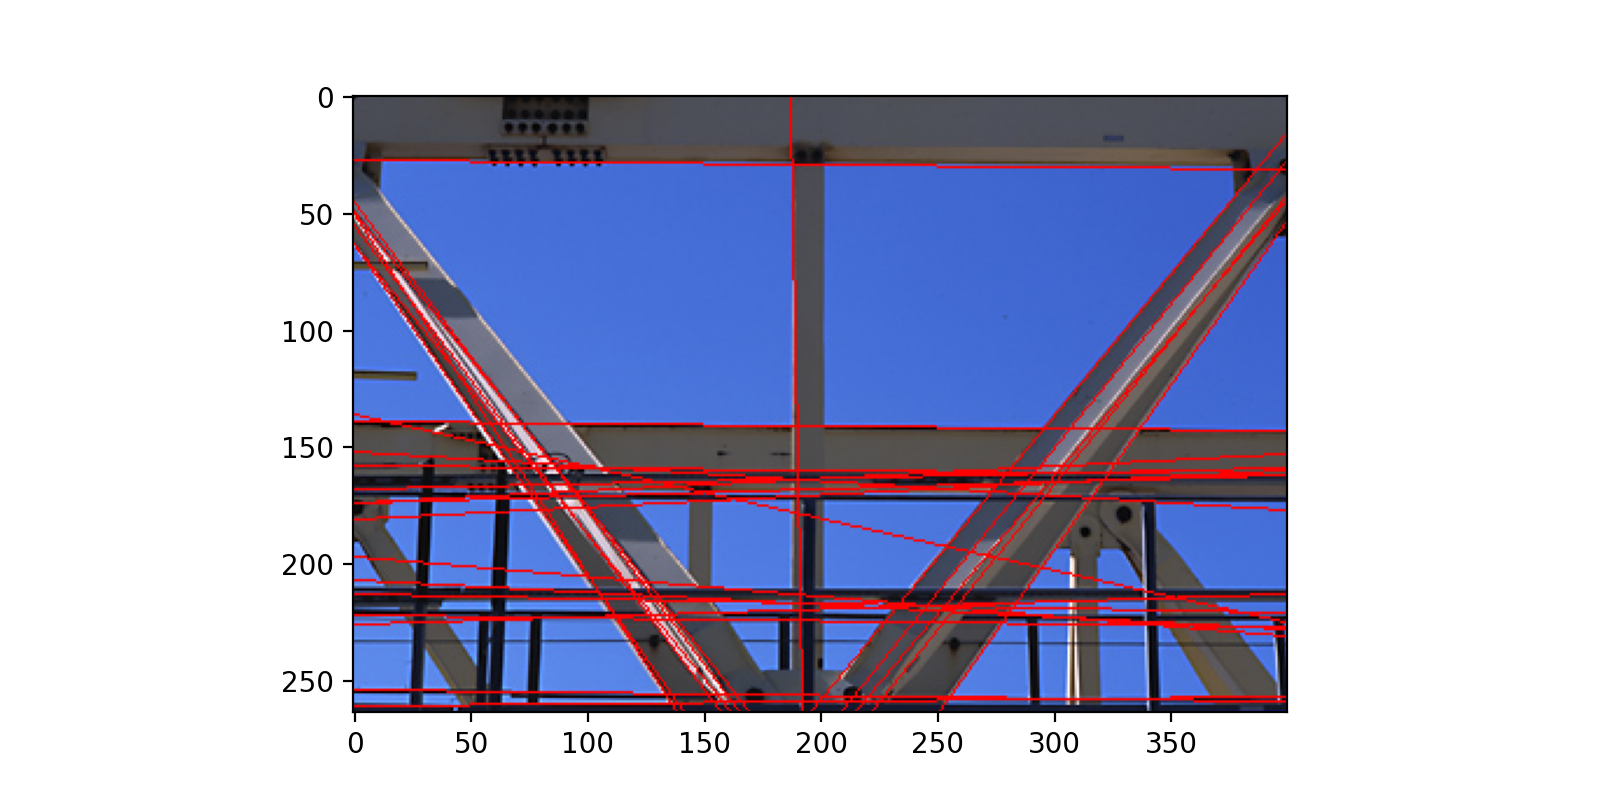

In [8]:
def plot_hough_lines(image, rho, theta):
    # compute start and ending point of the line x*cos(theta)+y*sin(theta)=rho
    x0, x1 = 0, image.shape[1] - 1
    y0 = rho / np.sin(theta)
    y1 = (rho - x1 * np.cos(theta)) / np.sin(theta)

    # Check out this page for more drawing function in OpenCV:
    # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    for yy0, yy1 in zip(y0, y1):
        cv2.line(image, (x0, int(yy0)), (x1, int(yy1)), color=(255, 0, 0), thickness=1)

    return image

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 200)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]

color_image = imageio.imread('gantrycrane.png')
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

circuit.png: found 40 lines in the image.


<IPython.core.display.Javascript object>


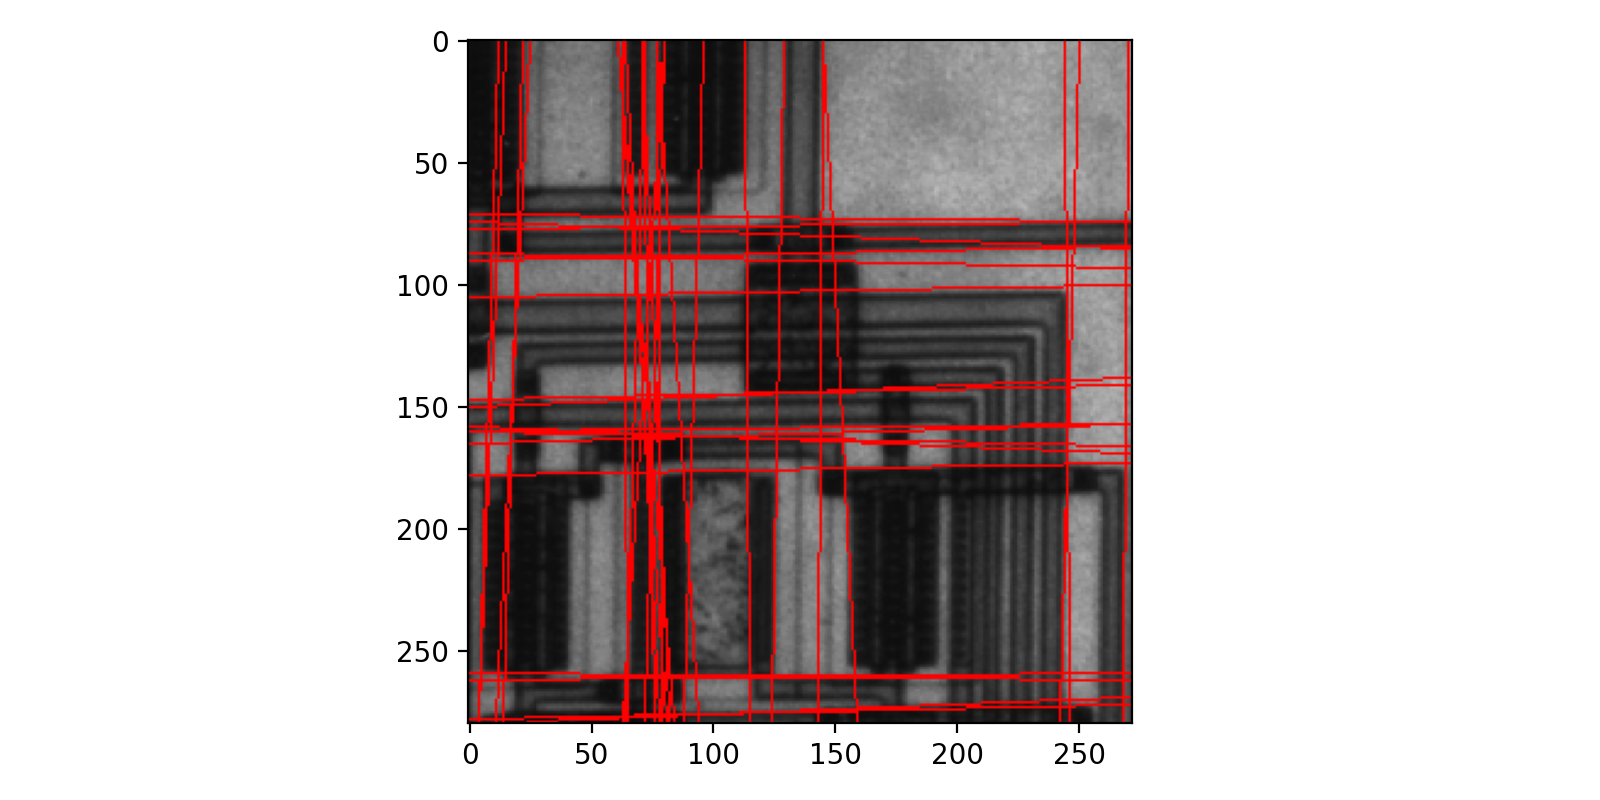

In [9]:
# Try another image
im = imageio.imread('circuit.png')

blurred = cv2.GaussianBlur(im, None, sigmaX=2)
edge = cv2.Canny(blurred, threshold1=30, threshold2=90)
hough_space, rho_bins, theta_bins = hough_transform(edge, n_bins_rho=300, n_bins_theta=300)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 100)
print(f'circuit.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]
color_image = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)
fig.tight_layout()